In [1]:
!wget https://dl3.pushbulletusercontent.com/uUN2AiPUxxvqfJlWaWhbhNQdZVrprSBu/code.zip
!unzip code.zip
!rm EC.py
!rm mnca.py

--2023-03-29 10:59:09--  https://dl3.pushbulletusercontent.com/uUN2AiPUxxvqfJlWaWhbhNQdZVrprSBu/code.zip
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4934 (4.8K) [application/x-zip-compressed]
Saving to: ‘code.zip’

code.zip            100%[===================>]   4.82K  --.-KB/s    in 0.001s  

2023-03-29 10:59:09 (5.11 MB/s) - ‘code.zip’ saved [4934/4934]

Archive:  code.zip
  inflating: EC.py                   
  inflating: mnca.py                 
  inflating: neighborhoods/mask_c1.txt  
  inflating: neighborhoods/mask_c2.txt  
  inflating: neighborhoods/mask_c3.txt  


In [2]:
!pip install deflate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 KB 6.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import deflate
import os
import sys
np.set_printoptions(threshold=sys.maxsize)



def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood



def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = 0.50 # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.40 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board

def mnca(range_of_neighborhood_sums):   

    ###############----CONSTANTS----###############
    width = 100
    height = 100
    steps = 50
    init_state = "random cells with some probability"
    # Fixed Neighbohoods
    nh1 = extract_neighborhood_from_file('neighborhoods/mask_c1.txt')
    nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
    nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')

    # neighborhoods = [nh1,nh2,nh3]
    neighborhoods = [nh1,nh2,nh3]
    board_arr = []
    board = init_board(width, height, init_state)
    ###############----CONSTANTS----###############


    for eachstep in range(steps):
        new_board = np.zeros_like(board, dtype=int)
        height, width = board.shape
        for i in range(height):
            for j in range(width):
                next_state = board[i, j]
                for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                    cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                        for ni, nj in neighborhood]
                    
                    # # use this for sum
                    # neighborhood_sum = sum(cell_neighborhood)
                    
                    # use this for average
                    neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                    for lower, upper, new_next_state in range_of_neighborhood_sum:
                        if lower <= neighborhood_sum <= upper:
                            next_state = new_next_state
                new_board[i, j] = next_state
        board[:] = new_board[:]
        board_arr.append(board)
    # Calculate Deflate over that board array
    
    try:
        os.remove("board_arrays.txt")
        # print("Removed Successfully")
    except:
        pass
    with open("board_arrays.txt", "w") as output:
        output.write(str(board_arr))
    
    # filedata = open('board_arrays.txt', "rb").readlines()
    # print(filedata)
    filedata = open('board_arrays.txt', 'r', encoding='utf-8').readlines()
    filedata = ''.join(filedata).encode('utf-8')
    # print(filedata)
    compressed = deflate.gzip_compress(filedata, 8)
    deflate_value = compressed.__sizeof__()
    os.system("rm *.txt")
    return deflate_value



# Testing handlers
known_rule = [[(0.451, 0.713, 0), (0.449, 0.663, 1), (0.191, 0.52, 1), (0.089, 0.296, 0)], [(0.332, 0.51, 0), (0.084, 0.307, 0), (0.182, 0.465, 1)], [(0.799, 0.902, 0), (0.303, 0.456, 0), (0.835, 0.984, 1)]]
range_of_neighborhood_sums = known_rule
# print(mnca(range_of_neighborhood_sums))



In [4]:
plot_data = []
for i in range(50):
  plot_data.append(mnca(range_of_neighborhood_sums))
  # running same rule for 50 simulations with 50 steps and appending the deflate values for plot
  # Expectation is all will be similar and chart should look stable over a small range of same values.

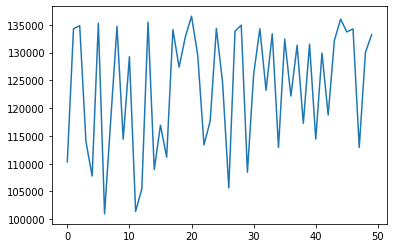

In [5]:
import matplotlib.pyplot as plt
plt.plot(plot_data)

In [10]:
# 50 random boards withj 50% chances of getting 1 and 50% chance of getting 0
import numpy as np

# Create a 2D grid of size 5x5
# grid = np.random.randint(2, size=(100, 100))

# print(grid)

# In the example code I provided using np.random.randint(2, size=(5, 5)), the 
# np.random.randint function generates random integers between 0 and 1 inclusive
# with a 50% probability of generating 0 and a 50% probability of generating 1.
random_deflates_to_plot = []
for i in range(50): # Experiemtns
  random_boards = []
  for i in range(50): # 50 steps
    random_boards.append(np.random.randint(2, size=(100, 100)))
  try:
      os.remove("board_arrays.txt")
      # print("Removed Successfully")
  except:
      pass
  with open("board_arrays.txt", "w") as output:
      output.write(str(random_boards))

  # filedata = open('board_arrays.txt', "rb").readlines()
  # print(filedata)
  filedata = open('board_arrays.txt', 'r', encoding='utf-8').readlines()
  filedata = ''.join(filedata).encode('utf-8')
  # print(filedata)
  compressed = deflate.gzip_compress(filedata, 8)
  deflate_value = compressed.__sizeof__()
  os.system("rm *.txt")
  # print(deflate_value)
  random_deflates_to_plot.append(deflate_value)


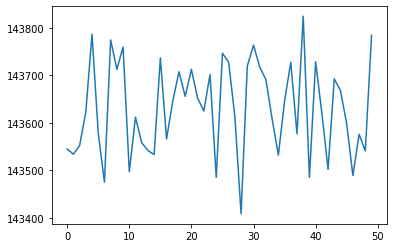

In [11]:
plt.plot(random_deflates_to_plot)

In [14]:
import matplotlib.pyplot as plt

def plot_lists(l1, l2, l3):
    """
    Plots two line plots and a scatter plot on the same figure using matplotlib.pyplot library.

    Arguments:
    l1 -- A list of y-axis values for the first line plot.
    l2 -- A list of y-axis values for the second line plot.
    l3 -- A list of x-axis values for the scatter plot.

    Returns:
    None
    """

    # Create the figure and axis objects
    fig, ax = plt.subplots()

    # Plot the first line plot
    ax.plot(l1, label='rule based delfates')

    # Plot the second line plot
    ax.plot(l2, label='random deflates plot')

    # Plot the scatter plot
    ax.scatter(l3, [0]*len(l3), marker='x', label='Base zero')

    # Set the labels for the x and y axes
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')

    # Set the title for the plot
    ax.set_title('Plot of Two Lines and a Scatter Plot')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()


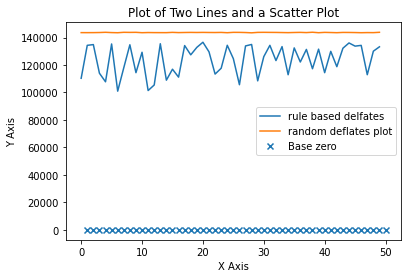

In [15]:


l1 = plot_data
l2 = random_deflates_to_plot
l3 = list(range(1, 51))

plot_lists(l1, l2, l3)
